# Modeling the TRAPPIST-1 spitzer granulation (?) noise

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

<Container object of 3 artists>

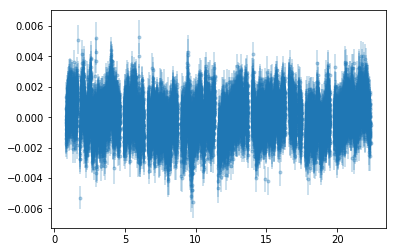

In [2]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')

plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.3)

In [3]:
import celerite
from celerite import terms

# # # Add celerite model terms:  one granulation, Q=1/sqrt(2), and one
# # # quasi-periodic, Q=3, with some initial model parameter values, to be optimized:
# # Q = 1.0 / np.sqrt(2.0)
# # # Characteristic timescale of ~2.0 days (to start),
# # # giving a break frequency of 2pi/2.0 ~ 3 rad/day:
# # w0 = 3.
# # # Initialize amplitude based on scatter in the data:
# # S0 = 0.01* np.var(y) / (w0 * Q)

# # Use the results from a prior optimization:
# kernel = terms.SHOTerm(-17.3028, -.5*np.log(2), 3.1111)

# # A single periodic component, with moderate Q value:
# Q = np.exp(-12.4969)
# # Chose a period of ~3 days (or frequency of 2pi/3 ~ 2.1 rad/day):
# w0 = np.exp(15.1479)
# S0 = np.exp(-17.3762)

# # A single periodic component, with moderate Q value:

# Q = np.exp(-12.4969)
# # Chose a period of ~3 days (or frequency of 2pi/3 ~ 2.1 rad/day):
# w0 = np.exp(15.1479)
# S0 = np.exp(-17.3762)
#kernel += terms.SHOTerm(np.log(S0), np.log(Q), np.log(w0))

kernel = terms.RealTerm(log_a=0, log_c=np.log(6),
                        bounds=dict(log_a=(-30, 30), log_c=(-30, 30)))
                        #bounds=dict(log_c=(np.log(5), np.log(7))))

#kernel += terms.ComplexTerm(0.05, -5, 2.5)

Then we wrap this kernel in a `GP` object that can be used for computing the likelihood function.

In [4]:
gp = celerite.GP(kernel, mean=np.mean(spitzer_flux))
gp.compute(spitzer_time, spitzer_err)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(spitzer_flux)))

Initial log likelihood: 13865.029640300283


In [5]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(spitzer_flux, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -66544.64600771593
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01164153,  0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 114
      nit: 2
   status: 0
  success: True
        x: array([-29.99999997, -30.        ])


In [6]:
gp.get_parameter_dict()
gp.kernel

RealTerm(-29.999999973577054, -30.0)

In [7]:
gp.log_likelihood(spitzer_flux)

66544.64600771593

In [8]:
#x = np.arange(spitzer_time.min(), spitzer_time.max(), 1/60/24)
x = np.arange(spitzer_time.min(), spitzer_time.max(), 1/24)
pred_mean, pred_var = gp.predict(spitzer_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [9]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(spitzer_flux) + lp

In [10]:
import emcee

initial = np.array(r.x)
ndim, nwalkers = len(initial), len(initial) * 2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                            threads=8) #pool=pool)

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 8000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...


/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


KeyboardInterrupt: 

In [10]:
# np.savetxt('spitzer_lc_gp_posteriors.txt', sampler.flatchain)
samples = np.loadtxt('spitzer_lc_gp_posteriors.txt')

In [11]:
np.median(samples, axis=0)

array([-14.49285716,   1.98108915])

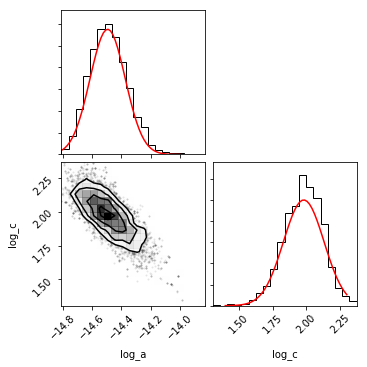

In [12]:
from corner import corner

fig = corner(samples, labels=['log_a', 'log_c'],  normed=True);

ax = fig.axes

x_log_a = np.linspace(-14.8, -14.0)
x_log_c = np.linspace(1.4, 2.3)

ax[0].plot(x_log_a, 1150 * np.exp(-0.5 * (x_log_a - np.median(samples, axis=0)[0])**2/0.12**2), 'r', zorder=10)
ax[3].plot(x_log_c, 1000 * np.exp(-0.5 * (x_log_c - np.median(samples, axis=0)[1])**2/0.15**2), 'r', zorder=10)
fig.savefig('exp_gp_posteriors.png', dpi=250, bbox_inches='tight')

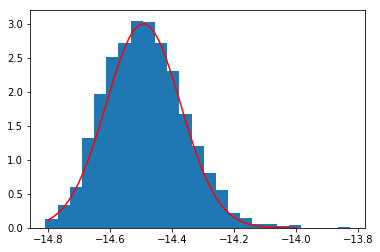

In [13]:
plt.hist(samples[:, 0], bins=25, normed=True)
plt.plot(x_log_a, 3 * np.exp(-0.5 * (x_log_a - np.median(samples, axis=0)[0])**2/0.12**2), 'r', zorder=10)

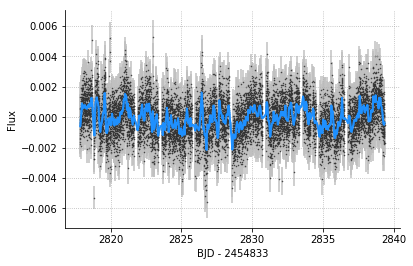

In [17]:
color = "DodgerBlue"
fig, ax = plt.subplots()

actual_spitzer_t0 = 7650 + 2450000
bjd_offset = 2454833


gp.set_parameter_vector(np.median(samples, axis=0))
pred_mean, pred_var = gp.predict(spitzer_flux, x, return_var=True)

ax.errorbar(spitzer_time + actual_spitzer_t0 - bjd_offset, spitzer_flux, yerr=spitzer_err, fmt=".", ecolor='silver', 
             capsize=0, color='#333333', zorder=-100, ms=1, rasterized=True)
ax.plot(x + actual_spitzer_t0 - bjd_offset, pred_mean, color=color, lw=2)
ax.fill_between(x + actual_spitzer_t0 - bjd_offset, pred_mean + pred_std, pred_mean - pred_std, color=color, alpha=0.5,
                 edgecolor="none")
ax.set_xlabel("BJD - 2454833")
ax.set_ylabel("Flux")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
ax.grid(ls=':')
fig.savefig('gp.pdf', bbox_inches='tight', dpi=250)
#plt.savefig()
#np.savetxt('../libra/data/spitzer_4.5um_gp.txt', 
#           np.vstack([x[~np.isnan(pred_mean)], 
#                      pred_mean[~np.isnan(pred_mean)]]).T)

In [14]:
np.median(samples, axis=0)

array([-14.49285716,   1.98108915])

In [25]:
# param_vector = np.array([-16.491909, -5.07083179, 7.06214525])

# kernel = terms.SHOTerm(log_S0=param_vector[0], 
#                        log_Q=param_vector[1], 
#                        log_omega0=param_vector[2])

# x = np.linspace(15, 40, 1000)

# gp = celerite.GP(kernel, mean=np.mean(spitzer_flux))
# gp.set_parameter_vector(param_vector)
# #gp.compute(spitzer_time)
# #pred_mean = gp.predict(spitzer_flux, spitzer_time, return_cov=False)
# gp.compute(spitzer_time, spitzer_err)
# pred_mean, pred_var = gp.predict(spitzer_flux, x, return_var=True)
# pred_std = np.sqrt(pred_var)
# plt.errorbar(spitzer_time, spitzer_flux, yerr=spitzer_err, fmt=".k", capsize=0, zorder=-100)
# plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
#                  edgecolor="none")
# plt.plot(x, pred_mean)

In [26]:
from interpacf import interpolated_acf

lag, acf = interpolated_acf(spitzer_time, spitzer_flux)
#lag *= 24
acf /= acf.max()

In [27]:
gp.kernel.get_value(lag)

array([  5.07963033e-07,   5.02595913e-07,   4.97285502e-07, ...,
         9.75738616e-75,   9.65428996e-75,   9.55228307e-75])

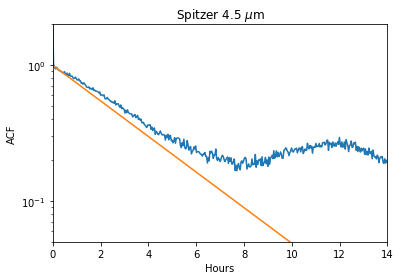

In [28]:
plt.semilogy(lag*24, acf/np.percentile(acf, 99.99))

kernel_acf = gp.kernel.get_value(lag)

plt.plot(lag*24, kernel_acf/kernel_acf.max())

# kernel2_acf = terms.ComplexTerm(0, -55, 2.6).get_value(lag)

# plt.plot(lag*24, kernel2_acf/kernel2_acf.max())

plt.xlim([0, 14])
plt.ylim([5e-2, 2])
plt.xlabel('Hours') 
plt.ylabel('ACF')
plt.title('Spitzer 4.5 $\mu$m')
plt.savefig('timescales.png', dpi=200)

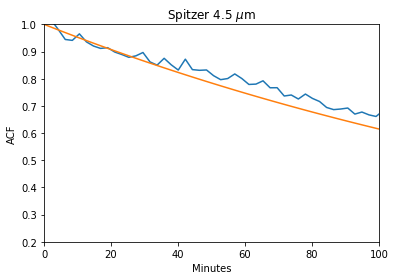

In [142]:
plt.plot(lag*60*24, acf/np.percentile(acf, 99.99))
plt.plot(lag*60*24, kernel_acf/kernel_acf.max())

plt.xlim([0, 100])
plt.ylim([.2, 1])
plt.xlabel('Minutes')
plt.ylabel('ACF')
plt.title('Spitzer 4.5 $\mu$m')
plt.savefig('timescales_min.png', dpi=200)

In [29]:
gp.set_parameter_vector(np.median(samples, axis=0))

In [1]:
# mu = gp.predict(np.random.randn(len(spitzer_time)) * np.std(spitzer_flux), spitzer_time, return_cov=False)
# mu += np.std(spitzer_flux) * np.random.randn(len(spitzer_time))

# fig, ax = plt.subplots(1, 2, figsize=(15, 4))
# ax[0].plot(spitzer_time, mu, '.', label='GP simulated samples')
# ax[0].legend()

# kernel_acf = gp.kernel.get_value(lag)

# lag_sim, acf_sim = interpolated_acf(spitzer_time, mu)
# ax[1].plot(lag_sim*24, acf_sim/np.percentile(acf_sim, 99.99), label='GP simulated samples ACF')
# ax[1].plot(lag*24, acf/np.percentile(acf, 99.99), label='actual Spitzer ACF', ls='--')

# ax[1].plot(lag*24, kernel_acf/kernel_acf.max(), label='Best-fit kernel', ls='--')

# ax[1].legend()
# ax[0].set(xlabel='Time [d]', ylabel='Simulated flux')

# ax[1].set(xlabel='lag [hour]', ylabel='ACF')
# ax[1].set_xlim([0, 5])
# fig.savefig('gp_sanity.png', bbox_inches='tight')

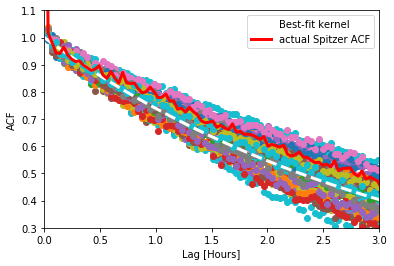

In [58]:
for rand in [gp.sample() for _ in range(50)]:
    lag_sample, acf_sample = interpolated_acf(spitzer_time, rand)
    plt.scatter(lag_sample*24, acf_sample/np.percentile(acf_sample, 99.99))

kernel_acf = gp.kernel.get_value(lag)
plt.plot(lag*24, kernel_acf/kernel_acf.max(), label='Best-fit kernel', ls='--', lw=3, color='white')
plt.plot(lag*24, acf/np.percentile(acf, 99.99), label='actual Spitzer ACF', lw=3, color='r')
plt.legend()
plt.xlim([0, 3])
plt.ylim([0.3, 1.1])
plt.xlabel('Lag [Hours]')
plt.ylabel('ACF')
plt.savefig('gp_sanity.png', bbox_inches='tight', dpi=200)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


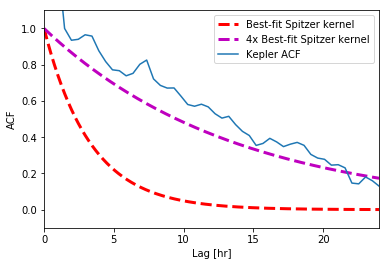

In [108]:
from astropy.io import fits

f = fits.getdata('../libra/data/trappist1/nPLDTrappist.fits')
k2_flux, k2_time = f['FLUX'], f['TIME']

k2_flux /= np.nanmedian(k2_flux)
mask = (k2_flux > 0.9) & (k2_flux < 1.5)
k2_flux = k2_flux[mask]
k2_time = k2_time[mask]

p = np.polyfit(k2_time, k2_flux, 5)
k2_flux -= np.polyval(p, k2_time)

# plt.plot(k2_time, k2_flux)

lag_k2, acf_k2 = interpolated_acf(k2_time, k2_flux - np.median(k2_flux))

plt.plot(lag*24, kernel_acf/kernel_acf.max(), label='Best-fit Spitzer kernel', ls='--', lw=3, color='r')

plt.plot(lag*24, np.exp(5.5 * lag) * kernel_acf/kernel_acf.max(), label='4x Best-fit Spitzer kernel', ls='--', lw=3, color='m')

plt.plot(lag_k2 * 24, acf_k2/acf_k2[3], label='Kepler ACF')
plt.xlim([0, 24])
plt.ylim([-0.1, 1.1])
plt.xlabel('Lag [hr]')
plt.ylabel('ACF')
plt.legend()
plt.savefig('spitzer_vs_k2.png', bbox_inches='tight', dpi=200)